# Imports

In [1]:
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

# Data Reading

In [4]:
daily = pd.read_csv('productDailyActions.csv')
attributes = pd.read_csv('productAttributes.csv')

In [5]:
combined = daily.join(attributes.set_index('productid'), 'productid')

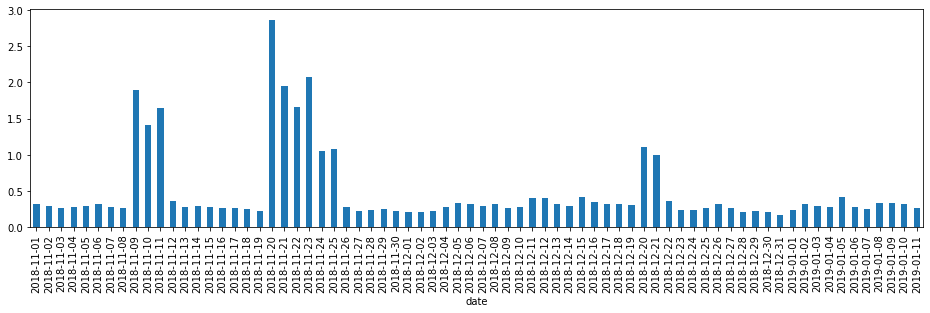

In [6]:
daily.groupby('date')['soldquantity'].mean().plot.bar(figsize=(16, 4))

In [7]:
#combined.drop(combined[(combined.date == '2018-11-09')].index, axis=0, inplace=True)
#combined.drop(combined[(combined.date == '2018-11-10')].index, axis=0, inplace=True)
#combined.drop(combined[(combined.date == '2018-11-11')].index, axis=0, inplace=True)

#combined.drop(combined[(combined.date == '2018-11-20')].index, axis=0, inplace=True)
#combined.drop(combined[(combined.date == '2018-11-21')].index, axis=0, inplace=True)
#combined.drop(combined[(combined.date == '2018-11-22')].index, axis=0, inplace=True)
#combined.drop(combined[(combined.date == '2018-11-23')].index, axis=0, inplace=True)
#combined.drop(combined[(combined.date == '2018-11-24')].index, axis=0, inplace=True)
#combined.drop(combined[(combined.date == '2018-11-25')].index, axis=0, inplace=True)

#combined.drop(combined[(combined.date == '2018-12-20')].index, axis=0, inplace=True)
#combined.drop(combined[(combined.date == '2018-12-21')].index, axis=0, inplace=True)

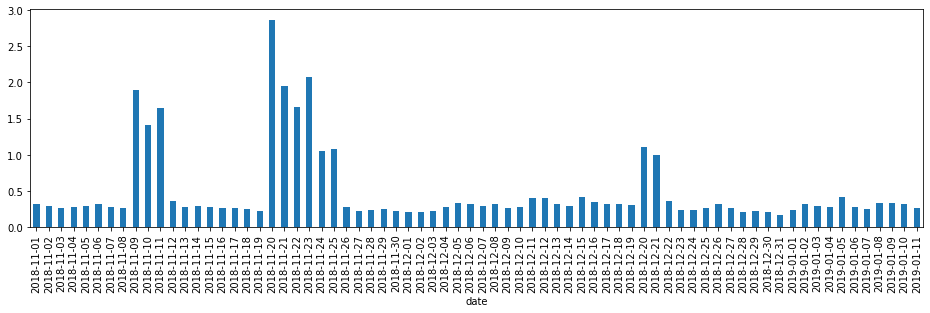

In [8]:
combined.groupby('date')['soldquantity'].mean().plot.bar(figsize=(16, 4))

## Dropping Features + Dealing with categorical variables 

In [9]:
for col in ['gender', 'color', 'categoryid', 'brandid', 'subcategoryid']:
    print(f"Unique number of values for {col}: {len(combined[col].unique())}")

Unique number of values for gender: 3
Unique number of values for color: 2243
Unique number of values for categoryid: 101
Unique number of values for brandid: 868
Unique number of values for subcategoryid: 103


### other than gender, the other features have way too many values to generate them as categorical values

In [10]:
combined = combined.drop(['color', 'categoryid', 'brandid', 'subcategoryid'], axis=1)

In [11]:
combined = pd.get_dummies(combined, columns=['gender'])

In [12]:
combined.head()

,productid,date,soldquantity,stock,clickcount,favoredcount,price,gender_1,gender_2,gender_3
0,1,2018-11-23,0,140,82.0,NaN,1996,1,0,0
1,21,2018-11-30,0,3,11.0,NaN,1100,0,1,0
2,21,2018-12-27,0,2,2.0,NaN,1100,0,1,0
3,21,2019-01-09,0,2,2.0,1.0,1100,0,1,0
4,21,2018-12-18,0,2,5.0,NaN,1100,0,1,0


In [13]:
p = combined[['soldquantity', 'productid']].groupby('productid').mean()

In [14]:
p.sort_values('soldquantity')

,soldquantity
productid,
91261,0.000000
84411,0.000000
45431,0.000000
111611,0.000000
111741,0.000000
...,...
191311,43.242424
19891,46.800000
190891,50.250000


# Data Engineering

In [15]:
combined['date'] = pd.to_datetime(combined['date'])

### Creating the target for each product

In [16]:
all_product_dfs = []

for product in combined['productid'].unique():
    product_df = combined[combined['productid']==product].sort_values('date').drop('date', axis=1).fillna(0)
    product_df['future_soldquantity'] = product_df['soldquantity'].shift(-1)
    product_df = product_df.dropna()
    all_product_dfs.append(product_df)

In [17]:
full_df = pd.concat(all_product_dfs).reset_index(drop=True)

In [18]:
full_df.shape

(839576, 10)

In [19]:
full_df

,productid,soldquantity,stock,clickcount,favoredcount,price,gender_1,gender_2,gender_3,future_soldquantity
0,1,0,140,82.0,0.0,1996,1,0,0,1.0
1,1,1,279,111.0,0.0,1996,1,0,0,1.0
2,1,1,139,60.0,0.0,1996,1,0,0,1.0
3,21,0,4,4.0,0.0,1100,0,1,0,0.0
4,21,0,4,2.0,0.0,1100,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...
839571,194631,1,1,25.0,2.0,98,0,1,0,0.0
839572,196261,2,2,116.0,13.0,184,0,1,0,0.0
839573,196361,0,1,4.0,0.0,305,0,1,0,1.0
839574,196361,1,1,6.0,0.0,305,0,1,0,0.0


### Now that we have all our data, we can go ahead and build a model for a single product, I do it on the most frequent product as a sample

In [20]:
temp_df = full_df[full_df['productid'] == full_df['productid'].value_counts().index[2]]

In [22]:
temp_df ##productid-57601

,productid,soldquantity,stock,clickcount,favoredcount,price,gender_1,gender_2,gender_3,future_soldquantity
229635,57601,0,330,187.0,3.0,3631,0,1,0,0.0
229636,57601,0,220,124.0,4.0,3631,0,1,0,0.0
229637,57601,0,218,79.0,4.0,3631,0,1,0,0.0
229638,57601,0,218,103.0,4.0,3631,0,1,0,0.0
229639,57601,0,218,102.0,4.0,3631,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...
229701,57601,0,78,94.0,2.0,3631,0,1,0,2.0
229702,57601,2,78,285.0,3.0,3631,0,1,0,0.0
229703,57601,0,150,154.0,8.0,3631,0,1,0,0.0
229704,57601,0,75,89.0,5.0,3631,0,1,0,1.0


In [23]:
temp_df = temp_df.drop('productid', axis=1)

In [24]:
full_x = temp_df.drop('future_soldquantity', axis=1)
full_y = temp_df['future_soldquantity']

In [25]:
temp_df

,soldquantity,stock,clickcount,favoredcount,price,gender_1,gender_2,gender_3,future_soldquantity
229635,0,330,187.0,3.0,3631,0,1,0,0.0
229636,0,220,124.0,4.0,3631,0,1,0,0.0
229637,0,218,79.0,4.0,3631,0,1,0,0.0
229638,0,218,103.0,4.0,3631,0,1,0,0.0
229639,0,218,102.0,4.0,3631,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...
229701,0,78,94.0,2.0,3631,0,1,0,2.0
229702,2,78,285.0,3.0,3631,0,1,0,0.0
229703,0,150,154.0,8.0,3631,0,1,0,0.0
229704,0,75,89.0,5.0,3631,0,1,0,1.0


# Train/Test Split

### The data is split into a 90% Train and 10% Test, from the 90% Train Cross Validation is also done on it.

In [26]:
X, test_X, y, test_y = train_test_split(full_x, full_y, test_size=0.1, random_state=0, shuffle=True)

# Gridsearch to find best models

### Logistic Regression

In [27]:
lr_gc = GridSearchCV(LinearRegression(), {'normalize':[False, True]}, scoring = 'neg_mean_absolute_error')

In [28]:
lr_gc.fit(X, y)

C:\Users\TCIDEMIRKAN\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='warn', n_jobs=None, param_grid={'normalize': [False, True]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [29]:
lr_gc.best_estimator_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [30]:
-lr_gc.best_score_

0.7905728370703312

## 0.79 MSE

### Random Forest

In [31]:
rf_gc = GridSearchCV(RandomForestRegressor(random_state=0), {'n_estimators':[10, 25, 100, 250], 'max_depth':[None, 1, 5, 10, 25]}, verbose=3, scoring='neg_mean_absolute_error')
rf_gc.fit(X, y)

C:\Users\TCIDEMIRKAN\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] max_depth=None, n_estimators=10 .................................
[CV] .... max_depth=None, n_estimators=10, score=-0.638, total=   0.0s
[CV] max_depth=None, n_estimators=10 .................................
[CV] .... max_depth=None, n_estimators=10, score=-0.776, total=   0.0s
[CV] max_depth=None, n_estimators=10 .................................
[CV] .... max_depth=None, n_estimators=10, score=-1.076, total=   0.0s
[CV] max_depth=None, n_estimators=25 .................................
[CV] .... max_depth=None, n_estimators=25, score=-0.720, total=   0.0s
[CV] max_depth=None, n_estimators=25 .................................
[CV] .... max_depth=None, n_estimators=25, score=-0.695, total=   0.0s
[CV] max_depth=None, n_estimators=25 .................................
[CV] .... max_depth=None, n_estimators=25, score=-1.114, total=   0.0s
[CV] max_depth=None, n_estimators=100 ................................
[CV] ... max_dep

[CV] ..... max_depth=25, n_estimators=250, score=-0.670, total=   0.1s
[CV] max_depth=25, n_estimators=250 ..................................
[CV] ..... max_depth=25, n_estimators=250, score=-1.116, total=   0.1s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    2.5s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [None, 1, 5, 10,

In [32]:
rf_gc.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [33]:
-rf_gc.best_score_

0.7786096994502587

## 0.77 MSE

## KNeighborsClassifier

In [34]:
knn_gc = GridSearchCV(KNeighborsRegressor(), {'n_neighbors':range(1,20)}, n_jobs=-1, return_train_score=True, scoring='neg_mean_absolute_error')
knn_gc.fit(X, y)

C:\Users\TCIDEMIRKAN\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=-1, param_grid={'n_neighbors': range(1, 20)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=0)

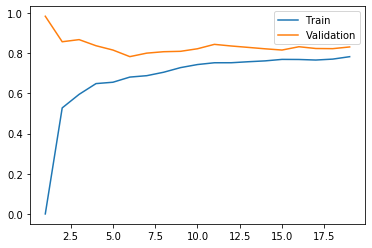

In [35]:
train_accuracy = knn_gc.cv_results_['mean_train_score']
test_accuracy = knn_gc.cv_results_['mean_test_score']

plt.plot(range(1, 20), -train_accuracy, label="Train")
plt.plot(range(1, 20), -test_accuracy, label="Validation")
plt.legend()
plt.show()

In [36]:
knn_gc.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                    weights='uniform')

In [37]:
-knn_gc.best_score_

0.7830687830687831

## 0.78 MSE

# Best model and test set
### Use the validation data, val_x and val_y to choose the best model

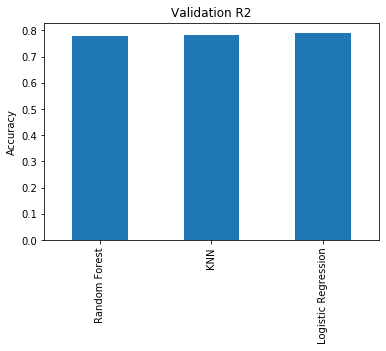

In [38]:
score_dict = pd.Series({"Logistic Regression":-lr_gc.best_score_, "Random Forest":-rf_gc.best_score_, "KNN":-knn_gc.best_score_})
score_dict.sort_values().plot(kind='bar', title="Validation R2")
plt.ylabel("Accuracy")
plt.show()

### Best Model is RF

In [39]:
from sklearn.metrics import mean_squared_error

In [40]:
mean_squared_error(rf_gc.predict(test_X), test_y)

0.3647438667354279

### 0.36 MSE

# Predictions

In [42]:
round(rf_gc.predict(full_x.iloc[-1:])[0])

1.0

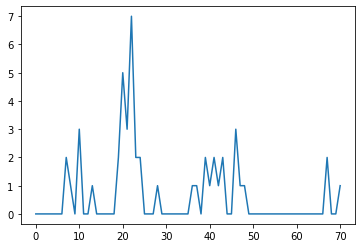

In [43]:
plt.plot(temp_df.reset_index(drop=True).index, temp_df['soldquantity'])

### The model predicts a sale of 1, which makes sense given the current sales this day and historical sales of the product

# Questions & Answers

## 1. How did you create the target variable?
### The Target variable was created by shifting the current sales per day one day backwards, so that tomorrow's value is used with todays features.

## 2. How did you prepare the final dataset for modeling?
### As shown above, the final dataset is created by first removing unnessarily large categorical features, one hot encoding the other categorical features and shifting the target timeseries.

## 3. How did you split datasets into training and testing?
### The dataset was split 90% Training, 10% Testing and Cross Validation was performed on the training split

## 4. What methods did you use for modelling and why?
### Linear Regression, Random Forest and KNN were used by running grid search to tune their hyperparameters to find each optimum model, then the best model was selected from the three.

## 5. How did you quantify the performance of your model(s)?
### The performances were quantified by using the mean absolute error, showing how much the model, on average, misses the actual amount of sales.